In [11]:
import numpy as np
import rioxarray as rxr
import rasterio as rio
from constants import home_dir
plt.style.use(home_dir+'stylefile.mplstyle')
import matplotlib.pyplot as plt

In [17]:
chm = rxr.open_rasterio('c:/users/marianne/documents/data/ASO/USCASJ_chm_3m_2021may3.tif')
#rxr.open_rasterio('c:/users/marianne/downloads/USCASJ_chm_3m.tif')
filename = 'c:/users/marianne/documents/data/ASO/USCASJ_chm_3m_2021may3.tif'

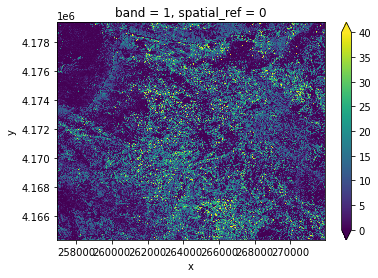

In [14]:
f,ax=plt.subplots()
chm[0,0:5000,0:5000].plot(ax=ax,vmin=0,vmax=40)
plt.show()

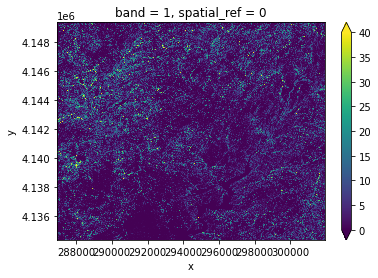

In [15]:
x=10000
y=10000
f,ax=plt.subplots()
chm[0,x:x+5000,y:y+5000].plot(ax=ax,vmin=0,vmax=40)
plt.show()

In [37]:
import rasterio
from rasterio.enums import Resampling

upscale_factor = 0.1

with rasterio.open(filename) as dataset:

    # resample data to target shape
    data = dataset.read(
        out_shape=(
            dataset.count,
            int(dataset.height * upscale_factor),
            int(dataset.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )
    height = int(dataset.height * upscale_factor)
    width = int(dataset.width * upscale_factor)
    profile = dataset.profile
    profile.update(transform=transform, driver='GTiff', height=height, width=width)
    with rasterio.open('resampled.tif', 'w', **profile) as dataset:  # Open as DatasetWriter
        dataset.write(data)

In [57]:
import geopandas as gpd
creekfire = gpd.read_file('c:/users/marianne/documents/creek_outline/creekfireoutline.shp')
creekfire_rp = creekfire.to_crs(chm_coarse.rio.crs)
rdnbr_rp = rdnbr.to_crs(chm_coarse.rio.crs)

AttributeError: 'DataArray' object has no attribute 'to_crs'

In [63]:
import matplotlib as mpl
filename = 'c:/users/marianne/downloads/ca3720111927220200905_20191123_20201202_ravg_data/ca3720111927220200905_20191123_20201202_rdnbr_cbi.tif'
filename = 'c:/users/marianne/downloads/ca3720111927220200905_20191123_20201202_ravg_data/ca3720111927220200905_20191123_20201202_dnbr.tif'


rdnbr = rxr.open_rasterio('c:/users/marianne/downloads/ca3720111927220200905_20191123_20201202_ravg_data/ca3720111927220200905_20191123_20201202_rdnbr_cbi.tif')
dnbr = rxr.open_rasterio(filename)

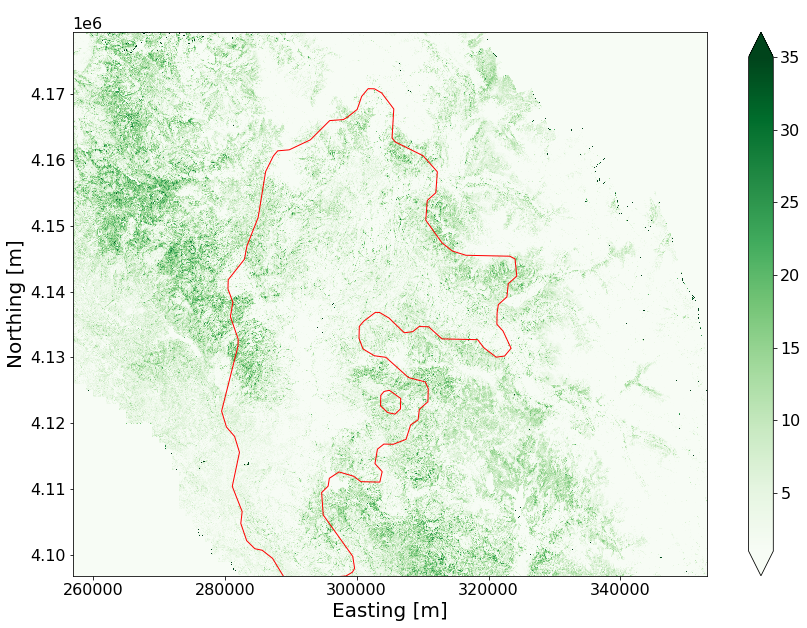

In [71]:
norm = None
cmap ='Greens'
chm_coarse = rxr.open_rasterio('resampled.tif')
f,ax=plt.subplots(figsize=(15,10))
chm_coarse.plot(ax=ax,vmin=1,vmax=35,cmap=cmap)
creekfire_rp.boundary.plot(ax=ax,color='red',linewidth=1)
ax.set_title(' ')
# rdnbr.plot(ax=ax,vmin=0,vmax=4,alpha=0.4,zorder=0)
ax.set_ylabel('Northing [m]')
ax.set_xlabel('Easting [m]')
plt.show()

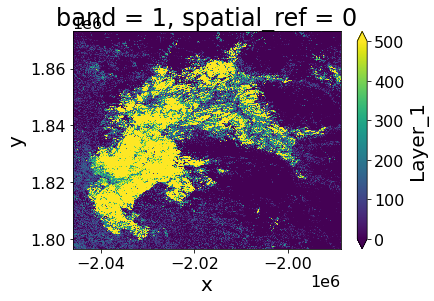

In [69]:
dnbr.plot(vmin=0,vmax=500)

In [54]:
#Create a mask of pixels with CHM < 20m
import numpy.ma as ma
import copy
rdnbr_array,rdnbr_ns_md=raster2array(filename)
#first copy the chm array so we can further select a subset (need to use copy because arrays are mutable/changeable)
rdnbr2_array = copy.copy(rdnbr_array)
rdnbr2_array[rdnbr<-1]=np.nan
rdnbr2_array[rdnbr>100]=np.nan


C:\Users\Marianne\AppData\Local\Temp/ipykernel_9360/3101063666.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
C:\Users\Marianne\AppData\Local\Temp/ipykernel_9360/251610954.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rdnbr2_array[rdnbr<-1]=np.nan
C:\Users\Marianne\AppData\Local\Temp/ipykernel_9360/251610954.py:8: F

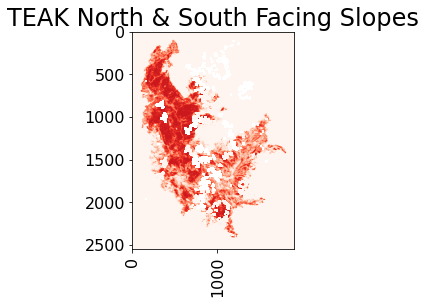

In [55]:
from matplotlib import colors
fig, ax = plt.subplots()
cmapNS = colors.ListedColormap(['white','blue','red'])
plt.imshow(rdnbr2_array,cmap='Reds',vmin=0,vmax=4)
plt.title('TEAK North & South Facing Slopes')
ax=plt.gca(); ax.ticklabel_format(useOffset=False, style='plain') #do not use scientific notation 
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90) #rotate x tick labels 90 degrees


In [42]:
#%load raster2array

from osgeo import gdal
import numpy as np

def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()
    
    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = mapinfo[0]
    metadata['ext_dict']['xMax'] = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    metadata['ext_dict']['yMin'] = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    metadata['ext_dict']['yMax'] = mapinfo[3]
    
    metadata['extent'] = (metadata['ext_dict']['xMin'],metadata['ext_dict']['xMax'],
                          metadata['ext_dict']['yMin'],metadata['ext_dict']['yMax'])
    
    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()
        
        # band statistics
        metadata['bandstats'] = {} #make a nested dictionary to store band stats in same 
        stats = raster.GetStatistics(True,True)
        metadata['bandstats']['min'] = round(stats[0],2)
        metadata['bandstats']['max'] = round(stats[1],2)
        metadata['bandstats']['mean'] = round(stats[2],2)
        metadata['bandstats']['stdev'] = round(stats[3],2)
        
        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[array==metadata['noDataValue']]=np.nan
        # array = array/metadata['scaleFactor']
        array = array[::-1] #inverse array because Python is column major
        return array, metadata
    
    elif metadata['bands'] > 1:
        print('More than one band ... need to modify function for case of multiple bands')

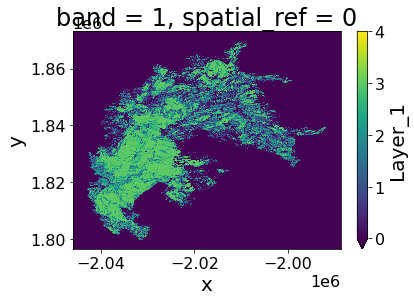

In [28]:
rdnbr.nodatava
rdnbr.plot(vmin=0,vmax=4)
plt.show()

<xarray.DataArray (band: 1, y: 2554, x: 1904)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -2.046e+06 -2.046e+06 ... -1.989e+06 -1.989e+06
  * y            (y) float64 1.873e+06 1.873e+06 ... 1.797e+06 1.797e+06
    spatial_ref  int32 0
Attributes: (12/18)
    LAYER_TYPE:                 athematic
    OVERVIEWS_ALGORITHM:        ErdasBino3
    STATISTICS_EXCLUDEDVALUES:  
    STATISTICS_HISTOBINVALUES:  63160|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0...
    STATISTICS_HISTOMAX:        3
    STATISTICS_HISTOMIN:        -9999
    ...                         ...
    STATISTICS_SKIPFACTORX:     1
    STATISTICS_SKIPFACTORY:     1
    STATISTICS_STDDEV:          1132.192628632
    scale_factor:               1.0
    add_offset:                 0.0
    long_name:                  Layer_1

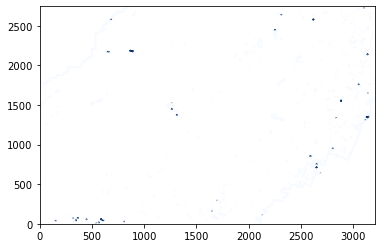

In [30]:
plt.contourf(data[0,:,:],vmin=0,vmax=40,cmap='Blues')
plt.show()